In [14]:
#Importing the neccesary library
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

In [15]:
#Importing the data
data = pd.read_csv("medical_insurance.csv", sep=",")
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


# Preprocessing

In [16]:
#First look
print("Missing values :")
print(data.isna().sum(axis=0))
print()
print("Data types")
print(data.dtypes)
print()
print(data.describe())
for var in data.select_dtypes(include="object").columns.to_list():
    print()
    print(data[var].value_counts())

Missing values :
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

Data types
age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

               age          bmi     children       charges
count  2772.000000  2772.000000  2772.000000   2772.000000
mean     39.109668    30.701349     1.101732  13261.369959
std      14.081459     6.129449     1.214806  12151.768945
min      18.000000    15.960000     0.000000   1121.873900
25%      26.000000    26.220000     0.000000   4687.797000
50%      39.000000    30.447500     1.000000   9333.014350
75%      51.000000    34.770000     2.000000  16577.779500
max      64.000000    53.130000     5.000000  63770.428010

sex
male      1406
female    1366
Name: count, dtype: int64

smoker
no     2208
yes     564
Name: count, dtype: int64

region
southeast    766
southwest    684
northwest    

# Analyse descriptive

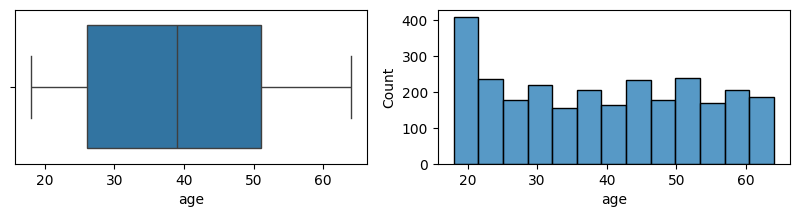

count    2772.000000
mean       39.109668
std        14.081459
min        18.000000
25%        26.000000
50%        39.000000
75%        51.000000
max        64.000000
Name: age, dtype: float64


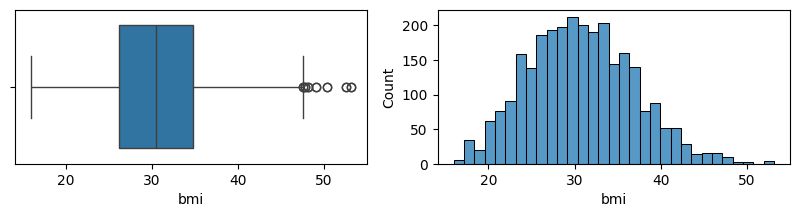

count    2772.000000
mean       30.701349
std         6.129449
min        15.960000
25%        26.220000
50%        30.447500
75%        34.770000
max        53.130000
Name: bmi, dtype: float64


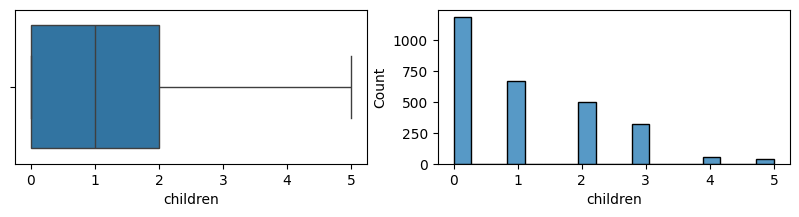

count    2772.000000
mean        1.101732
std         1.214806
min         0.000000
25%         0.000000
50%         1.000000
75%         2.000000
max         5.000000
Name: children, dtype: float64


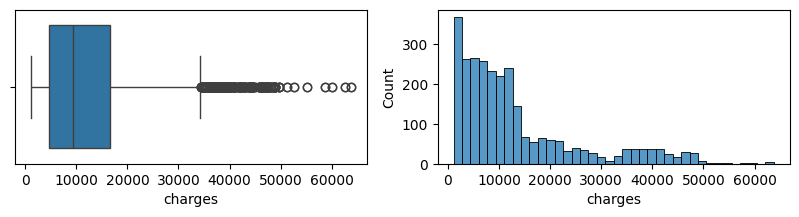

count     2772.000000
mean     13261.369959
std      12151.768945
min       1121.873900
25%       4687.797000
50%       9333.014350
75%      16577.779500
max      63770.428010
Name: charges, dtype: float64


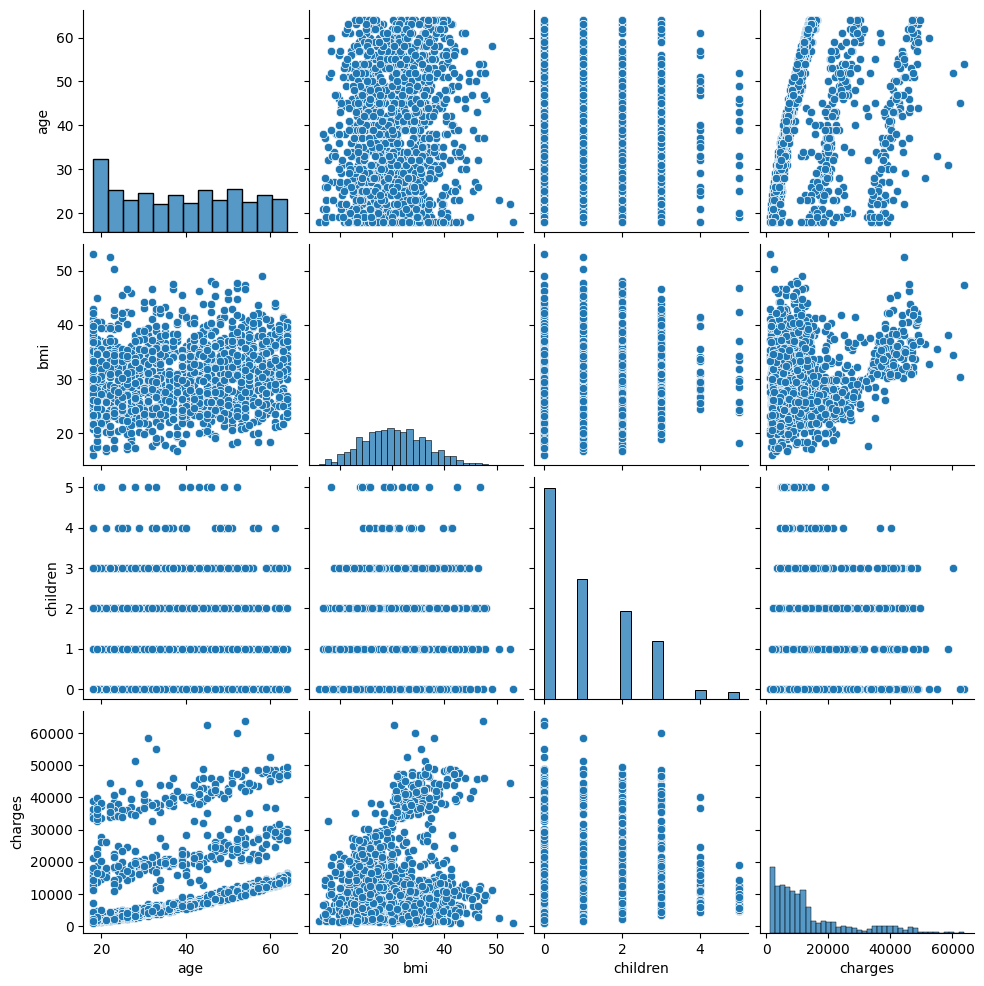

In [17]:
#Visualisation
for var in data.select_dtypes("number").columns:
    fig, axs = plt.subplots(1,2,figsize=(10,2))
    sns.boxplot(data, x = var, whis = 1.5, ax = axs[0])
    sns.histplot(data,x=var, ax = axs[1])
    plt.show()
    print(data[var].describe())

sns.pairplot(data)
plt.show()

In [26]:
#Relation entre les variables catégorielles
nom_var = ["sex","smoker","region"]
seuil_corr_nom = 0
for i,var in enumerate(nom_var):
    ct_tab = []
    cr_tab = []
    for j in range(i+1,len(nom_var)):
        #print("i :", i, " j :", j)
        ct_tab.append(pd.crosstab(index=data[nom_var[i]], columns=data[nom_var[j]]))
        cr_tab.append(stats.contingency.association(ct_tab[j-1-i],correction=False,method="cramer"))
        if(cr_tab[j-i-1] >= seuil_corr_nom):
            print("Cramér's coefficient of", nom_var[i], "and", nom_var[j]," : ", cr_tab[j-i-1])

#Relation avec Target
for i,var in enumerate(nom_var):
    ct = pd.crosstab(index=data["charges"], columns=data[nom_var[i]])
    cr = stats.contingency.association(ct,correction=False,method="cramer")
    if(cr >= 0.3):
        print("Cramér's coefficient of Target and", nom_var[i]," : ", cr)

Cramér's coefficient of sex and smoker  :  0.08232647745208163
Cramér's coefficient of sex and region  :  0.024768087180991518
Cramér's coefficient of smoker and region  :  0.07906136988750963
Cramér's coefficient of Target and sex  :  1.0
Cramér's coefficient of Target and smoker  :  0.9999999999999999
Cramér's coefficient of Target and region  :  1.0


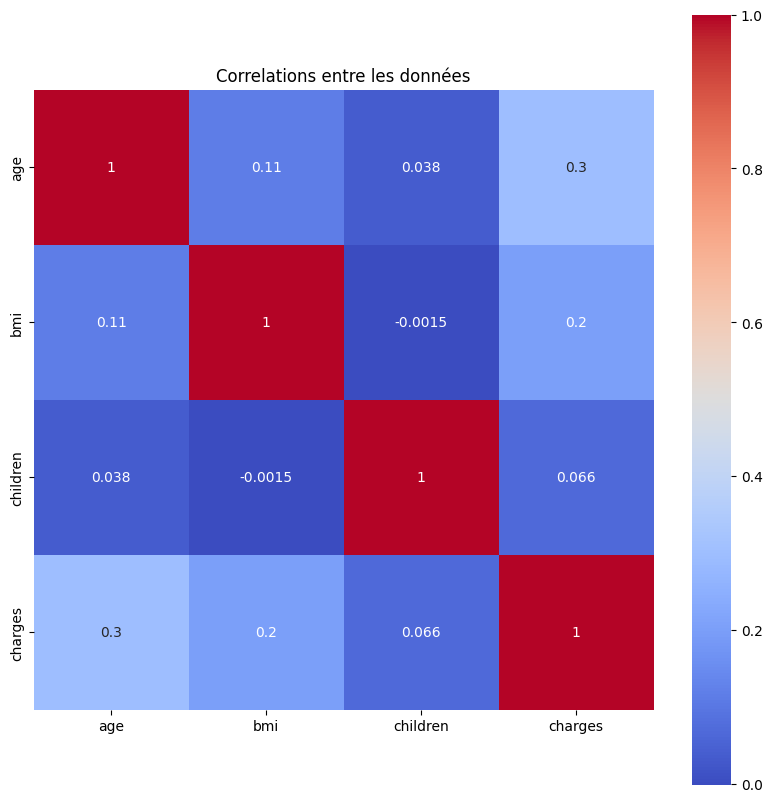

In [19]:
#Linear correlations
X = data.select_dtypes("number")
X_corr = X.corr()
plt.figure(figsize=(10,10))
sns.heatmap(X_corr, annot=True,cmap = 'coolwarm', square=True)
plt.title('Correlations entre les données')
plt.show()

# from sklearn.metrics.pairwise import rbf_kernel, polynomial_kernel, pairwise_kernels, sigmoid_kernel
# X_corr_rbf1 = pairwise_kernels(X,metric="linear")
# print(pd.DataFrame(X_corr_rbf1).corr())

# plt.figure(figsize=(10,10))
# sns.heatmap(X_corr, annot=True,cmap = 'coolwarm', square=True)
# plt.title('Correlations entre les données')
# plt.show()

In [20]:
#Encoding
#Since each categorical variable (3 of the six explaining variables) have only 2 (for sex and smoker) or 4 values (for region), we can do a one hot encoding.
#It will generate only 6 columns resulting in 9 columns used in total to predict the charges (we drop the 3 categorical variables and replace them with their dummies).
cat_var = data.select_dtypes("object").columns

encoder = OneHotEncoder(drop = "if_binary",sparse_output=False)
output = encoder.fit_transform(data[cat_var])
df_output = pd.DataFrame(output, columns=["sex_male","smoker_yes","region_northeast","region_northwest","region_southeast","region_southwest"])
df_output.shape 
# print(data.head())
# print(df_output.head())

data_processed = data.copy()
data_processed.drop(["sex","smoker","region"], axis=1, inplace=True)
data_processed[["sex_male","smoker_yes","region_northeast","region_northwest","region_southeast","region_southwest"]] = df_output
data_processed.head()


,age,bmi,children,charges,sex_male,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,0.0,1.0,0.0,0.0,0.0,1.0
1,18,33.770,1,1725.55230,1.0,0.0,0.0,0.0,1.0,0.0
2,28,33.000,3,4449.46200,1.0,0.0,0.0,0.0,1.0,0.0
3,33,22.705,0,21984.47061,1.0,0.0,0.0,1.0,0.0,0.0
4,32,28.880,0,3866.85520,1.0,0.0,0.0,1.0,0.0,0.0


In [21]:
#Adding a constant columns 
data_processed["const"] = pd.Series(np.ones(shape=(2772,)))
data_processed.head()

,age,bmi,children,charges,sex_male,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest,const
0,19,27.900,0,16884.92400,0.0,1.0,0.0,0.0,0.0,1.0,1.0
1,18,33.770,1,1725.55230,1.0,0.0,0.0,0.0,1.0,0.0,1.0
2,28,33.000,3,4449.46200,1.0,0.0,0.0,0.0,1.0,0.0,1.0
3,33,22.705,0,21984.47061,1.0,0.0,0.0,1.0,0.0,0.0,1.0
4,32,28.880,0,3866.85520,1.0,0.0,0.0,1.0,0.0,0.0,1.0


Faire beaucoup d'analyse descriptive 


# Model implementation

## Linear Model

In [22]:
#First LinearRegression => full model
y = data_processed["charges"]
X = data_processed.drop("charges", axis=1)
X

X_train, X_test, y_train,y_test = train_test_split(X,y, test_size=0.2, random_state=42)

results = sm.OLS(y_train,X_train).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.754
Model:                            OLS   Adj. R-squared:                  0.753
Method:                 Least Squares   F-statistic:                     844.2
Date:                Fri, 21 Nov 2025   Prob (F-statistic):               0.00
Time:                        22:04:03   Log-Likelihood:                -22432.
No. Observations:                2217   AIC:                         4.488e+04
Df Residuals:                    2208   BIC:                         4.493e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
age                254.4825      9.250  

In [23]:
#Stepwise model selection : forward
y = data_processed["charges"]
col = data_processed.columns
col = col.drop("charges")
list_col = ["const"]

for var in col:
    list_col.append(var) 
    print("\nVariables used :")
    print(list_col)
    X = data_processed[list_col]

    X_train, X_test, y_train,y_test = train_test_split(X,y, test_size=0.2, random_state=42)

    results = sm.OLS(y_train,X_train).fit()
    print(results.summary())



Variables used :
['const', 'age']
                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.080
Model:                            OLS   Adj. R-squared:                  0.080
Method:                 Least Squares   F-statistic:                     193.3
Date:                Fri, 21 Nov 2025   Prob (F-statistic):           3.35e-42
Time:                        22:04:03   Log-Likelihood:                -23892.
No. Observations:                2217   AIC:                         4.779e+04
Df Residuals:                    2215   BIC:                         4.780e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3707.

In [24]:
##Stepwise model selection : backward
y = data_processed["charges"]
col = data_processed.columns
col = col.drop("charges")
list_col = col

for var in col:
    
    print("\nVariables used :")
    if(len(list_col.to_list())>0):
        print(list_col.to_list())
        X = data_processed[list_col]

        X_train, X_test, y_train,y_test = train_test_split(X,y, test_size=0.2, random_state=42)

        results = sm.OLS(y_train,X_train).fit()
        print(results.summary())

        list_col = list_col.drop(var) 
    else:
        print("Backward ended")


Variables used :
['age', 'bmi', 'children', 'sex_male', 'smoker_yes', 'region_northeast', 'region_northwest', 'region_southeast', 'region_southwest', 'const']
                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.754
Model:                            OLS   Adj. R-squared:                  0.753
Method:                 Least Squares   F-statistic:                     844.2
Date:                Fri, 21 Nov 2025   Prob (F-statistic):               0.00
Time:                        22:04:03   Log-Likelihood:                -22432.
No. Observations:                2217   AIC:                         4.488e+04
Df Residuals:                    2208   BIC:                         4.493e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t 

## Gamma Model

Because no negative values